In [35]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [36]:
def propensity_score(x: np.ndarray):
    return sp.special.expit(x)

In [37]:
def conditional_expectation(d: np.ndarray, x: np.ndarray):
    return np.sin(d * x + (1 - d) * x**2)

In [102]:
def individual_treatment(x: np.ndarray):
    return conditional_expectation(1, x) - conditional_expectation(0, x)

In [109]:
def average_treatment_effect():
    """Assumes that x follows a Uniform[-2, 2] distribution."""
    integral, tol = sp.integrate.quad(individual_treatment, a=-2, b=2)
    return integral / 4

## Plotting

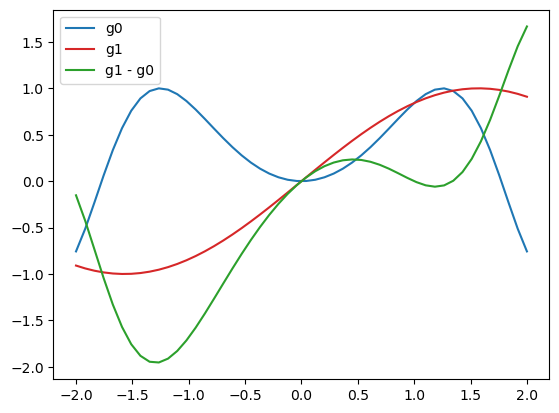

In [83]:
_x = np.linspace(-2, 2)
g0 = conditional_expectation(0, _x)
g1 = conditional_expectation(1, _x)

fig, ax = plt.subplots(1, 1)
ax.plot(_x, g0, color="tab:blue")
ax.plot(_x, g1, color="tab:red")
ax.plot(_x, g1 - g0, color="tab:green")
ax.legend(labels=["g0", "g1", "g1 - g0"])

In [71]:
def simulate(n_samples: int, rng: np.random.Generator):
    x = rng.uniform(low=-2, high=2, size=n_samples)
    treatment_probability = propensity_score(x)
    d = rng.binomial(1, p=treatment_probability, size=n_samples)
    g = conditional_expectation(d, x)
    error = rng.normal(scale=0.05, size=n_samples)
    y = g + error
    return x, d.astype(bool), y

In [72]:
rng = np.random.default_rng(12345)

In [139]:
x, d, y = simulate(10_000, rng=rng)

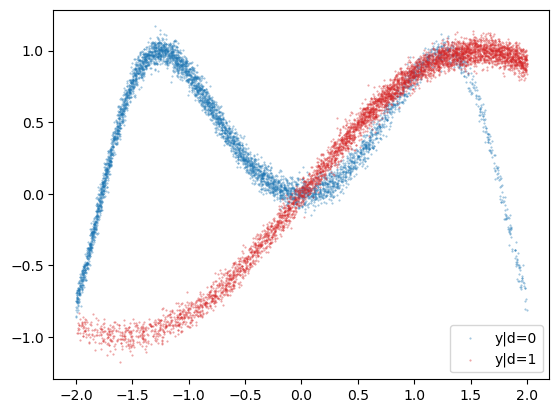

In [140]:
fig, ax = plt.subplots(1, 1)

ax.scatter(x[~d], y[~d], color="tab:blue", alpha=0.5, s=0.2)
ax.scatter(x[d], y[d], color="tab:red", alpha=0.5, s=0.2)
ax.legend(labels=["y|d=0", "y|d=1"])

In [141]:
def oracle_estimator(x, d, y):
    z = (
        conditional_expectation(1, x)
        - conditional_expectation(0, x)
        + d * (y - conditional_expectation(1, x)) / propensity_score(x)
        - (1 - d) * (y - conditional_expectation(0, x)) / (1 - propensity_score(x))
    )
    estimate = np.mean(z)
    variance = np.mean((z - estimate) ** 2)
    return {"estimate": estimate, "variance": variance}

In [142]:
def mean_difference(x, d, y):
    return y[d].mean() - y[~d].mean()

In [143]:
oracle = oracle_estimator(x, d, y)
estimate = oracle["estimate"]
ate = average_treatment_effect()
md = mean_difference(x, d, y)

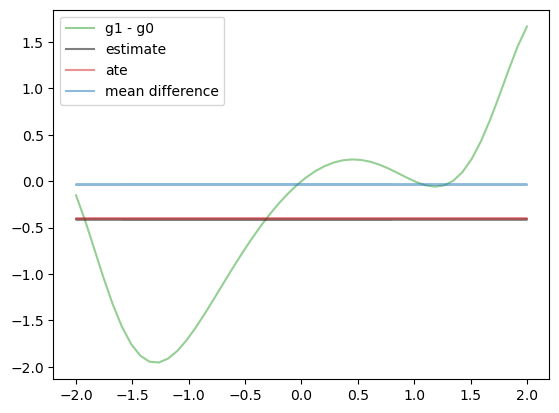

In [144]:
_x = np.linspace(-2, 2)
g0 = conditional_expectation(0, _x)
g1 = conditional_expectation(1, _x)


fig, ax = plt.subplots(1, 1)
ax.plot(_x, g1 - g0, color="tab:green", alpha=0.5)
ax.plot(x, [estimate] * len(x), color="black", alpha=0.5)
ax.plot(x, [ate] * len(x), color="tab:red", alpha=0.5)
ax.plot(x, [md] * len(x), color="tab:blue", alpha=0.5)
ax.legend(labels=["g1 - g0", "estimate", "ate", "mean difference"])